In [29]:
import os, sys, argparse, importlib, time, inspect
import numpy as np
import matplotlib.pyplot as plt
import os.path as osp
if hasattr(__builtins__,'__IPYTHON__'):
    print('Notebook')
    notebook=1
    from tqdm.notebook import tqdm
else:
    print('Not notebook')
    notebook=0
    from tqdm import tqdm
from tensorflow.keras import backend as K
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import tensorflow as tf
import tensorflow_probability as tfp

gpu_devices = tf.config.list_physical_devices('GPU') 
if len(gpu_devices) > 0:
    print("GPU detected")
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('No GPU detected')

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.models import load_model, Model
import spektral
from sklearn.preprocessing import normalize
from spektral.data import DisjointLoader, BatchLoader, SingleLoader
from importlib import reload
import winsound
import dill
import datetime as dt
import plotly

Notebook
GPU detected


In [30]:
tf.__version__, spektral.__version__

('2.4.1', '1.0.3')

In [31]:
#everything here could be JSON

################################################
# Setup Deafult Variables                       # 
################################################
learning_rate = 2.5e-4
warm_up       = 4
batch_size    = 512
epochs        = 20
n_data       = 1e4
scenario    = "probreg_test"
patience = 5
angleunit = 'angle'

################################################
# Setup Model hyperparameters                  # 
################################################

#Make model.config

hidden_states = 'N/A'
forward       = False
dropout       = 'None'

################################################
# Setup Other Hyperparameters                   # 
################################################

#add "SRT_cleaned or not"

loss_method   = "von Mises"
n_neighbors   = 6 # SKRIV SELV IND
wandblog      = 1
opt = Adam(learning_rate)

if wandblog:
    import wandb
    !wandb login b5b917a9390932e56fccfcbff6f528ccd85c44bf
    #checks
    wandb.init(project="icecube", group=scenario,entity="chri862z")

    # Declare for log
    wandb.config.angleunit=angleunit
    wandb.config.hidden_states = hidden_states
    wandb.config.n_data = n_data
    wandb.config.forward = forward
    wandb.config.dropout = dropout
    wandb.config.learning_rate = learning_rate
    wandb.config.warm_up = warm_up
    wandb.config.batch_size = batch_size
    wandb.config.loss_func = loss_method
    wandb.config.n_neighbors = n_neighbors
    wandb.config.optimizer = 'Adam'
    wandb.run.name = wandb.run.id
    wandbname=wandb.run.id

wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\chris/.netrc


_runtime,2328
_timestamp,1615585335
_step,31
Train Loss,-0.23889
Validation Loss,-0.20564
Energy metric,0.23488
Energy bias,0.14823
Energy sig+1,0.04229
Energy sig-1,0.37434
Angle metric,47.44897
Angle bias,36.84243


_runtime,▁▁▁▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
Train Loss,█▆▂▁▁▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁
Validation Loss,█▃▂▂▂▄▂▂▃▃▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁
Energy metric,▅▃▃▂▁█▁▃▂▃▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁
Energy bias,█▃▂▁▁▄▂▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
Energy sig+1,█▃▂▁▁▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
Energy sig-1,█▄▂▁▁▅▂▁▁▂▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁
Angle metric,▂▂▂▃█▂▁▄▅▃▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁
Angle bias,▄▂▃▃█▄▂▅▇▅▃▄▃▂▄▁▁▁▁▁▁▁▁▁▁


wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [32]:
################################################
# Load data                      # 
################################################

import data_load as dl
reload(dl)
graph_data=dl.graph_data
dataset=graph_data(n_data=n_data, restart=0, transform=True, angle=True, unitvec=False)
idx_lists = dataset.index_lists
# Split data
dataset_train = dataset[idx_lists[0]]
dataset_val   = dataset[idx_lists[1]]
dataset_test  = dataset[idx_lists[2]]

loader_train = DisjointLoader(dataset_train, epochs=epochs, batch_size=batch_size) # the different loaders work very very differently, beware
loader_test = DisjointLoader(dataset_test, batch_size=batch_size, epochs=1)

winsound.Beep(400,300)

Not notebook
Loading data to memory


In [33]:
def metrics(y_reco, y_true):
    energy_metric = tfp.stats.percentile(tf.math.abs(tf.subtract(y_true[:, 0], y_reco[:, 0])), [50-34, 50, 50+34]) 
    #for compariso
    classic_stat=tfp.stats.percentile(tf.subtract(y_true[:, 0], y_reco[:, 0]), [25, 75]) 
    w_energy=tf.subtract(classic_stat[1],classic_stat[0])/1.349
    
    alpha= tf.math.acos(tf.math.sin(y_reco[:, 1])*tf.math.sin(y_true[:, 1])*tf.math.cos(tf.subtract(y_reco[:, 2],y_true[:, 2]))+tf.math.cos(y_reco[:, 1])*tf.math.cos(y_true[:, 1]))
   
    angle_resi = 180 / np.pi * alpha #degrees
    angle_metric  = tfp.stats.percentile(angle_resi, [50-34,50,50+34])
    w_angle         = tfp.stats.percentile(angle_resi, [68])

    return energy_metric.numpy(), angle_metric.numpy(), [float(w_energy), float(w_angle)]


In [34]:
def metrics_zeniazi(y_reco, y_true):
    w_zeni=180/np.pi*tfp.stats.percentile(tf.math.abs(tf.subtract(y_true[:, 1], y_reco[:, 1]%(np.pi/2))),[50-34, 50, 50+34, 68])
    w_azi=180/np.pi*tfp.stats.percentile(tf.math.abs(tf.subtract(y_true[:, 2], y_reco[:, 2]%(np.pi*2))),[50-34, 50, 50+34, 68])
    return w_zeni, w_azi

In [35]:
def loss_func(y_reco, y_true, re=False):
    loss_energy = tf.reduce_mean((tf.subtract(y_reco[:,0], y_true[:,0]))**2)
    kappa=tf.math.abs(y_reco[:,3])
#     tf.print(tf.reduce_mean(kappa))
    zep = y_reco[:,1] #Zenith prediction
    zet = y_true[:,1] #Zenith target
    azp = y_reco[:,2] #Azimuth prediction
    azt = y_true[:,2] #Azimuth target
    s1 = tf.math.sin(zet + azt - azp )
    s2 = tf.math.sin( zet - azt + azp )
    c1 = tf.math.cos( zet - zep )
    c2 = tf.math.cos( zet + zep )
    cos_angle = 0.5*tf.math.abs(tf.math.sin(zep))*( s1 + s2 ) + 0.5*(c1 + c2)
    nlogC = - tf.math.log(kappa) + kappa + tf.math.log( 1 - tf.math.exp( - 2 * kappa) )

    loss_angle = tf.reduce_mean( - kappa*cos_angle + nlogC )
    if not re:
        return loss_angle+loss_energy
    if re:
        return float(loss_angle+loss_energy), [float(loss_energy), float(loss_angle)]

In [36]:
def alpha_from(y_reco, y_true):
    
    azp = y_reco[:,2] #Azimuth prediction
    azt = y_true[:,2] #Azimuth target
    zep = y_reco[:,1] #Zenith prediction
    zet = y_true[:,1] #Zenith target
    s1 = tf.math.sin(zet + azt - azp )
    s2 = tf.math.sin( zet - azt + azp )
    c1 = tf.math.cos( zet - zep )
    c2 = tf.math.cos( zet + zep )
    cos_angle = 0.5*tf.math.abs(tf.math.sin(zep))*( s1 + s2 ) + 0.5*(c1 + c2)
    angle=tf.math.acos(cos_angle)
    return angle

In [37]:
################################################
# Load Model and do checks                      # 
################################################
import models.GCS as m
reload(m)
# model=m.GCN0(6)
model=m.model(n_out=4)
# model.compile('adam', 'categorical_crossentropy') ## this is a basic setup with predetermined optimizers and so on

In [ ]:
def performance_e_alpha(loader, save=False, save_path=''):
    '''Function to test and plot performance of Graph DL
    input should be dom pos x,y,z , time, charge(log10)
    target should be energy(log10),zenith angle, azimuthal angle, NOT unit vec 
    '''
    loss = 0
    prediction_list, target_list = [], []
    for batch in loader:
        inputs, targets = batch
        predictions, targets, out = test_step(inputs, targets)
        loss           += out
        
        prediction_list.append(predictions)
        target_list.append(targets)

    y_reco  = tf.concat(prediction_list, axis = 0).numpy()
    y_true  = tf.concat(target_list, axis = 0)
    y_true  = tf.cast(y_true, tf.float32).numpy()

    energy = y_true[:, 0]
    counts, bins = np.histogram(energy, bins = 10)

    xs = (bins[1:] + bins[: -1]) / 2

    w_energies, u_angles = [], []
    e_sig, alpha_sig = [], [] 
    old_energy, old_alpha = [], []
    zenith, azimuth = [], []
    for i in range(len(bins)-1):
        idx = np.logical_and(energy > bins[i], energy < bins[i + 1])

        w, u_angle, old = metrics(y_reco[idx, :], y_true[idx, :])
        old_energy.append(old[0])
        old_alpha.append(old[1])
        w_energies.append(w[1])
        u_angles.append(u_angle[1])
        e_sig.append([w[0], w[2]])
        alpha_sig.append([u_angle[0], u_angle[2]])
        zeni, azi=metrics_zeniazi(y_reco[idx,:], y_true[idx,:])
        zenith.append(zeni)
        azimuth.append(azi)
    zenith, azimuth =  np.array(zenith), np.array(azimuth)
    fig, ax = plt.subplots(ncols = 3, nrows = 4, figsize = (12, 20))
    axesback=[(0,0), (0,1), (1,0), (1,1), (2,0), (3,0)]
    for i,j in axesback:
        a_ = ax[i][j].twinx()
        a_.step(xs, counts, color = "gray", zorder = 10, alpha = 0.7, where = "mid")
        a_.set_yscale("log")
        ax[i][j].set_xlabel("Log(E)")

    #structure: my metrics, old metrics, histogram
    
    # Energy reconstruction
    ax_top = ax[0]

    ax_top[0].errorbar(xs, w_energies,yerr=np.array(e_sig).T, fmt='k.',capsize=2,linewidth=1,ecolor='r',label='data')
    ax_top[0].set_title("Energy Performance")
    ax_top[0].set_ylabel(r"$\Delta log(E)$")

    ax_top[1].plot(xs, old_energy, 'bo')
    ax_top[1].set_title("Energy Performance (old metric)")
    ax_top[1].set_ylabel(r"$w(\Delta log(E))$")

    ax_top[2].hist2d(y_true[:,0], y_reco[:,0], bins=100,\
                   range=[np.percentile(y_true[:,0],[1,99]), np.percentile(y_reco[:,0],[1,99])])
    ax_top[2].set_title("ML Reco/True")
    ax_top[2].set(xlabel="Truth (log(E))", ylabel="ML Reco (log(E))")


    # Alpha reconstruction
    ax_m=ax[1]

    ax_m[0].errorbar(xs, u_angles,yerr=np.array(alpha_sig).T, fmt='k.',capsize=2,linewidth=1,ecolor='r',label=r'Median $\pm \sigma$')
    ax_m[0].set_title("Angle Performance")
    ax_m[0].set_ylabel(r"$\Delta \Omega$")

    ax_m[1].plot(xs, old_alpha, 'bo')
    ax_m[1].set_title("Angle performance (old metric)")
    ax_m[1].set_ylabel(r"$w(\Omega)$")

    alphas=alpha_from(y_reco, y_true)
    
    ax_m[2].hist2d(np.abs(y_reco[:,3]), alphas, bins=100, \
                   range=[np.percentile(np.abs(y_reco[:,3]),[1,99]), np.percentile(alphas,[1,99])])
    ax_m[2].set_title("ML Kappa correlation with angle error")
    ax_m[2].set(xlabel=r"$\kappa$", ylabel=r"$\Delta \Omega$")
    for axi in ax_m:
        axi.legend()
    #Zenith reconstruction
    ax_z=ax[2]

    ax_z[0].errorbar(xs, zenith[:,1],yerr=[zenith[:,0], zenith[:,2]], fmt='k.',capsize=2,linewidth=1,ecolor='r',label=r'Median $\pm \sigma$')
    ax_z[0].set_title("Zenith Performance")
    ax_z[0].plot(xs, zenith[:,3], 'bo', label='68th')
    ax_z[0].set_ylabel(r"$\Delta \Theta$")
    
    reszeni=np.abs(y_reco[:, 1]%(np.pi/2)-y_true[:,1])
    ax_z[1].hist(reszeni, label = "ML reco - Truth", histtype = "step", bins = 50)
    ax_z[1].hist(y_reco[:, 1]%(np.pi/2), label = "ML reco", histtype = "step", bins = 50)
    ax_z[1].hist(y_true[:, 1], label = "Truth", histtype = "step", bins = 50)
    
    ax_z[1].set_title("Zenith Perfomance")
    ax_z[1].set_ylabel(r"$\Theta$")
    
    ax_z[2].hist2d(np.abs(y_reco[:,3]), reszeni, bins=100,\
                  range=[np.percentile(np.abs(y_reco[:,3]),[1,99]), np.percentile(reszeni,[1,99])])
    ax_z[2].set_title("ML Kappa correlation with zenith error")
    ax_z[2].set(xlabel=r"$\kappa$", ylabel=r"$\Delta \Theta$")
    for axi in ax_z:
        axi.legend()
    #Azimuth reconstruction
    
    ax_az=ax[3]

    ax_az[0].errorbar(xs, azimuth[:,1],yerr=[azimuth[:,0], azimuth[:,2]], fmt='k.',capsize=2,linewidth=1,ecolor='r',label=r'Median $\pm \sigma$')
    ax_az[0].set_title("Azimuth Performance")
    ax_az[0].plot(xs, azimuth[:,3], 'bo', label='68th')
    ax_az[0].set_ylabel(r"$\Delta \phi$")
    
    resazi=np.abs(y_reco[:, 2]%(2*np.pi)-y_true[:,2])
    ax_az[1].hist(resazi, label = "ML reco - Truth", histtype = "step", bins = 50)
    ax_az[1].hist(y_reco[:, 2]%(2*np.pi), label = "ML reco", histtype = "step", bins = 50)
    ax_az[1].hist(y_true[:, 2], label = "Truth", histtype = "step", bins = 50)
    
    ax_az[1].set_title("Azimuth Perfomance")
    ax_az[1].set_ylabel(r"$\phi$")
    
    ax_az[2].hist2d(np.abs(y_reco[:,3]), resazi, bins=100,\
                  range=[np.percentile(np.abs(y_reco[:,3]),[1,99]), np.percentile(resazi,[1,99])])
    ax_az[2].set_title("ML Kappa correlation with azimuth error")
    ax_az[2].set(xlabel=r"$\kappa$", ylabel=r"$\Delta \phi$")
    for axi in ax_az:
        axi.legend()
    fig.tight_layout()
    if save:
        fig.save(save_path)
    return fig, ax

In [39]:
# ################################################
# # Setup functions                            # 
# ################################################
# import loss.loss_funcs as loss_funcs
# reload(loss_funcs)
# loss_func=loss_funcs.loss_funcangle

def lr_schedule(epochs = epochs, initial = learning_rate, warm_up=warm_up, decay = 0.9):
    n = 1
    lr = initial
    yield lr
    while n < warm_up:
        lr *= 2
        n  += 1
        yield lr
    while True:
        lr *= decay
        n  += 1 
        yield lr


#make functions into tf functions

@tf.function(input_signature = loader_train.tf_signature(), experimental_relax_shapes = True)
def train_step(inputs, targets):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training = True)
        targets     = tf.cast(targets, tf.float32)
        loss        = loss_func(predictions, targets)
        loss       += sum(model.losses)

    gradients = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

@tf.function(input_signature = loader_test.tf_signature(), experimental_relax_shapes = True)
def test_step(inputs, targets):
    predictions = model(inputs, training = False)
    targets     = tf.cast(targets, tf.float32) 
    out         = loss_func(predictions, targets)

    return predictions, targets, out


def validation(loader):
    loss = 0
    prediction_list, target_list = [], []
    for batch in loader:
        inputs, targets = batch
        predictions, targets, out = test_step(inputs, targets)
        loss           += out
        
        prediction_list.append(predictions)
        target_list.append(targets)
    
    y_reco  = tf.concat(prediction_list, axis = 0)
    y_true  = tf.concat(target_list, axis = 0)
    y_true  = tf.cast(y_true, tf.float32)

    loss, loss_from = loss_func(y_reco, y_true, re=True)
    
    energy, angle, old= metrics(y_reco, y_true)
    
    return loss, loss_from, [energy, angle, old]

New folder for saving probreg_test made
New folder for saving run o9hov3lt
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ecc_conv_3 (ECCConv)         multiple                  29696     
_________________________________________________________________
gcs_conv_12 (GCSConv)        multiple                  8192      
_________________________________________________________________
gcs_conv_13 (GCSConv)        multiple                  16384     
_________________________________________________________________
gcs_conv_14 (GCSConv)        multiple                  65536     
_________________________________________________________________
gcs_conv_15 (GCSConv)        multiple                  262144    
_________________________________________________________________
global_max_pool_3 (GlobalMax multiple                  0         
__________________________________________________

Exception ignored in: <function tqdm.__del__ at 0x000002B2A5E6C790>
Traceback (most recent call last):
  File "C:\Users\chris\anaconda3\lib\site-packages\tqdm\std.py", line 1122, in __del__
    self.close()
  File "C:\Users\chris\anaconda3\lib\site-packages\tqdm\notebook.py", line 257, in close
    super(tqdm_notebook, self).close(*args, **kwargs)
  File "C:\Users\chris\anaconda3\lib\site-packages\tqdm\std.py", line 1323, in close
    fp_write('')
  File "C:\Users\chris\anaconda3\lib\site-packages\tqdm\std.py", line 1320, in fp_write
    self.fp.write(_unicode(s))
  File "C:\Users\chris\anaconda3\lib\site-packages\tqdm\utils.py", line 223, in inner
    return func(*args, **kwargs)
  File "C:\Users\chris\anaconda3\lib\site-packages\wandb\sdk\lib\redirect.py", line 100, in new_write
    cb(name, data)
  File "C:\Users\chris\anaconda3\lib\site-packages\wandb\sdk\wandb_run.py", line 729, in _console_callback
    self._backend.interface.publish_output(name, data)
  File "C:\Users\chris\anac

Avg loss of validation: 5.074457
Loss from:  Energy: 4.918980 	 Angle: 0.155477 
Energy: bias = 2.173562 sig_range = 1.951960<->2.446016, old metric 0.235410              
 Angle: bias = 38.357491 sig_range = 19.978601<->60.162724, old metric 49.022152
Early stop counter: 0/5, lowest loss was 5.074457


Epoch 2 of 20 done in 64.79 seconds using learning rate: 5.00E-04
Avg loss of train: 3.692489
Avg loss of validation: 1.955406
Loss from:  Energy: 2.201766 	 Angle: -0.246360 
Energy: bias = 1.409678 sig_range = 1.116566<->1.758685, old metric 0.339229              
 Angle: bias = 39.221363 sig_range = 19.977003<->62.500549, old metric 50.530319
Early stop counter: 0/5, lowest loss was 1.955406


Epoch 3 of 20 done in 72.69 seconds using learning rate: 1.00E-03
Avg loss of train: 0.228836
Avg loss of validation: -0.241801
Loss from:  Energy: 0.192121 	 Angle: -0.433922 
Energy: bias = 0.278430 sig_range = 0.088640<->0.557182, old metric 0.378684              
 Angle: bias = 40.137802 sig_range = 19.909241<->69.640442, old metric 54.683090
Early stop counter: 0/5, lowest loss was -0.241801


Epoch 4 of 20 done in 74.27 seconds using learning rate: 2.00E-03
Avg loss of train: -0.397967
Avg loss of validation: 0.213920
Loss from:  Energy: 0.104214 	 Angle: 0.109707 
Energy: bias = 0.189499 sig_range = 0.056885<->0.418907, old metric 0.273602              
 Angle: bias = 48.461571 sig_range = 25.385033<->77.767967, old metric 61.895531
Early stop counter: 1/5, lowest loss was -0.241801


Epoch 5 of 20 done in 74.99 seconds using learning rate: 1.80E-03
Avg loss of train: -0.517771
Avg loss of validation: -0.060241
Loss from:  Energy: 0.239150 	 Angle: -0.299390 
Energy: bias = 0.291384 sig_range = 0.089525<->0.631008, old metric 0.417911              
 Angle: bias = 50.892967 sig_range = 24.311090<->82.372696, old metric 66.166977
Early stop counter: 2/5, lowest loss was -0.241801


INFO:tensorflow:Assets written to: C:\Users\chris\Christian\3YR-UNI\Bachelor\IceCube\trained_models/probreg_test\o9hov3lt\assets


INFO:tensorflow:Assets written to: C:\Users\chris\Christian\3YR-UNI\Bachelor\IceCube\trained_models/probreg_test\o9hov3lt\assets


Model saved


Epoch 6 of 20 done in 72.84 seconds using learning rate: 1.62E-03
Avg loss of train: -0.646662
Avg loss of validation: -0.458905
Loss from:  Energy: 0.135699 	 Angle: -0.594604 
Energy: bias = 0.261622 sig_range = 0.086367<->0.506003, old metric 0.380288              
 Angle: bias = 49.035133 sig_range = 21.518719<->87.124458, old metric 68.316986
Early stop counter: 0/5, lowest loss was -0.458905


KeyboardInterrupt: 

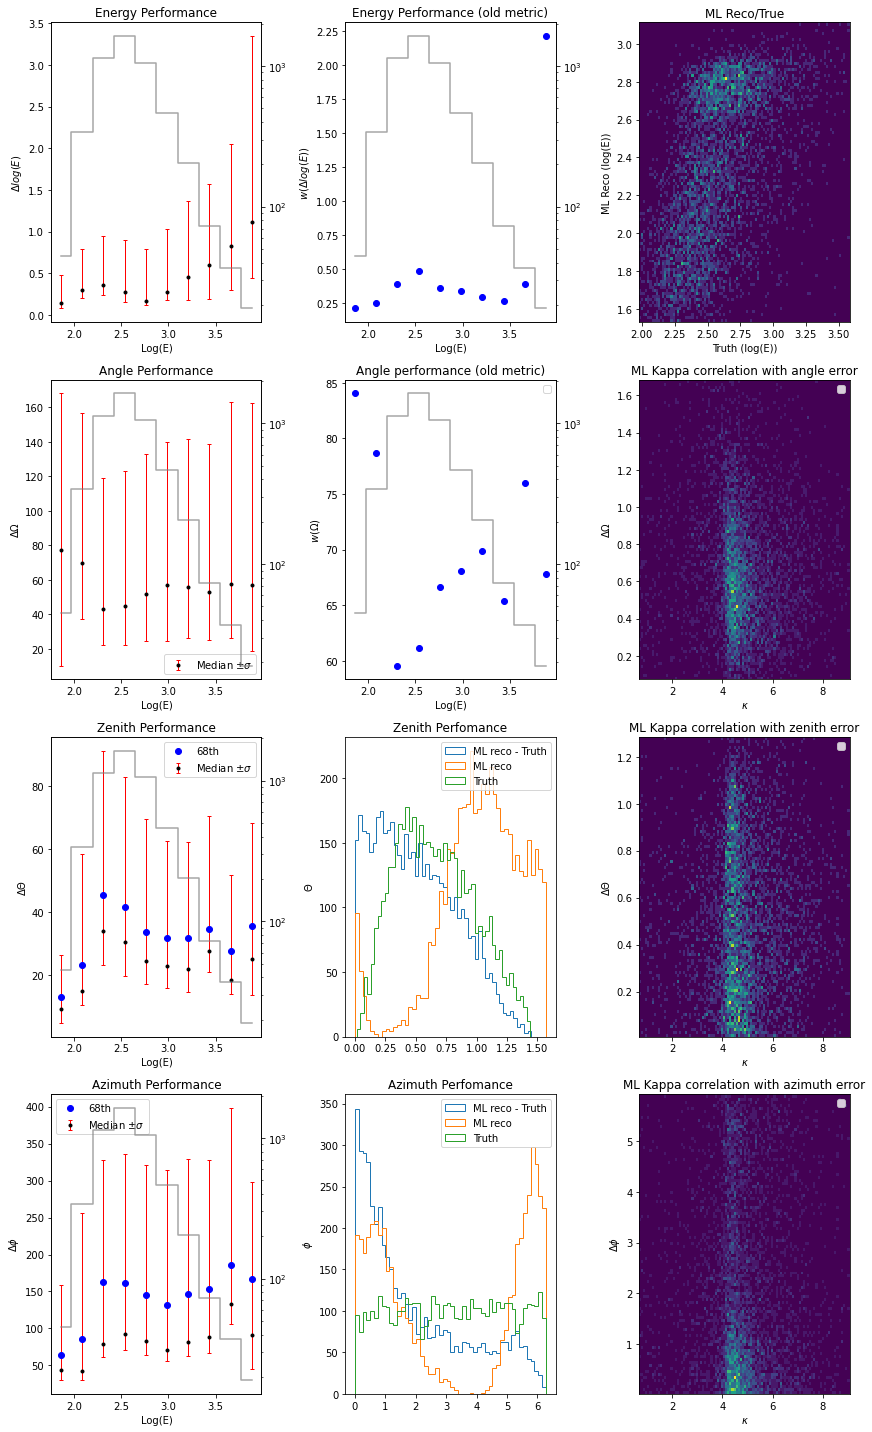

In [40]:
k=0
if notebook:
    k=0.2
tot_time=0
current_batch = 0
current_epoch = 1
loss          = 0
lowest_loss   = np.inf
early_stop    = 1
early_stop_counter    = 0
if notebook:
    pbar0          = tqdm(total = epochs, position = 0, leave = True)
    pbar0.set_description(f"Epochbar")
pbar          = tqdm(total = loader_train.steps_per_epoch, position = k, leave = True)
start_time    = time.time()
lr_gen        = lr_schedule(initial=learning_rate)
learning_Rate = next(lr_gen)
cwd = osp.abspath('')
save_path = osp.join(cwd, 'trained_models/'+scenario)
if not osp.isdir(save_path):
    os.makedirs(save_path)
    print('New folder for saving '+scenario+' made')
# Implement saving model archictecture to wandb
save_path = osp.join(save_path, wandbname)
if not osp.isdir(save_path):
    os.makedirs(save_path)
    print('New folder for saving run '+wandbname)
summarylist=[]
for batch in loader_train:
    inputs, targets = batch
    out             = train_step(inputs, targets)
    loss           += out
    if current_epoch==1 and current_batch==0:
        model.summary()
        if wandblog:
            summary=model.summary(print_fn=summarylist.append)
            table=wandb.Table(columns=["Layers"])
            for s in summarylist:
                table.add_data(s)
            wandb.log({'Model summary': table})
            n_params=np.sum([np.prod(v.get_shape()) for v in model.variables])
            wandb.config.n_params=n_params
    current_batch  += 1
    pbar.update(1)
    pbar.set_description(f"Epoch {current_epoch} / {epochs}; Avg_loss: {loss / current_batch:.6f}")
    
    
    if current_batch == loader_train.steps_per_epoch:
        t=time.time() - start_time
        tot_time+=t
        print(f"Epoch {current_epoch} of {epochs} done in {t:.2f} seconds using learning rate: {learning_rate:.2E}")
        print(f"Avg loss of train: {loss / loader_train.steps_per_epoch:.6f}")

        loader_val    = DisjointLoader(dataset_val, epochs = 1,      batch_size = batch_size)
        val_loss, val_loss_from, val_metric = validation(loader_val)
#         val_loss, val_metric = validation(loader_val)
        if wandblog:
            wandb.log({"Train Loss":      loss / loader_train.steps_per_epoch,
                       "Validation Loss": val_loss, 
                       "Energy metric":   val_metric[2][0],
                       "Energy bias":   val_metric[0][1],
                       "Energy sig+1":   val_metric[0][0],
                       "Energy sig-1":   val_metric[0][2],
                       "Angle metric":    val_metric[2][1],
                       "Angle bias":   val_metric[1][1],
                       "Angle sig+1":   val_metric[1][0],
                       "Angle sig-1":   val_metric[1][2],
                       "Learning rate":   learning_rate})

        print(f"Avg loss of validation: {val_loss:.6f}")
        print(f"Loss from:  Energy: {val_loss_from[0]:.6f} \t Angle: {val_loss_from[1]:.6f} ")
        print(f"Energy: bias = {val_metric[0][1]:.6f} sig_range = {val_metric[0][0]:.6f}<->{val_metric[0][2]:.6f}, old metric {val_metric[2][0]:.6f}\
              \n Angle: bias = {val_metric[1][1]:.6f} sig_range = {val_metric[1][0]:.6f}<->{val_metric[1][2]:.6f}, old metric {val_metric[2][1]:.6f}")

        if val_loss < lowest_loss:
            early_stop_counter = 0
            lowest_loss        = val_loss
        else:
            early_stop_counter += 1
        print(f'Early stop counter: {early_stop_counter}/{patience}, lowest val loss was {lowest_loss:.6f}')
        if early_stop and (early_stop_counter >= patience):
            model.save(save_path)
            print(f"Stopped training. No improvement was seen in {patience} epochs")
            break

        if current_epoch != epochs:
            pbar          = tqdm(total = loader_train.steps_per_epoch, position = k, leave = True)

        learning_rate = next(lr_gen)
        opt.learning_rate.assign(learning_rate)
        if notebook:
            pbar0.update(1)
        time_avg=tot_time/current_epoch
        delta=dt.timedelta(seconds=time_avg*(epochs-current_epoch))
        now = dt.datetime.now()
        then=now+delta
        time_e = then.strftime("%H:%M:%S")
        if notebook:
            pbar0.set_description(f"Expect to finish at {time_e}")
        if current_epoch % patience == 0:
            model.save(save_path)
            print("Model saved")
            if wandblog:
                loader_test = DisjointLoader(dataset_test, batch_size=batch_size, epochs=1)
                fig, ax = performance_e_alpha(loader_test, save=True, save_path=save_path)
                title="Metricsplot_"+str(current_epoch)
                wandb.log({title: [wandb.Image(fig, caption=title)]})
    
        loss            = 0
        start_time      = time.time()
        current_epoch  += 1
        current_batch   = 0
winsound.Beep(400,300)

In [ ]:
loader_test = DisjointLoader(dataset_test, batch_size=batch_size, epochs=1)
fig, ax = performance_e_alpha(loader_test)
# if wandblog:
#     fig.savefig(f"model_tests/{scenario}_"+wandbname".pdf")

In [ ]:
def performance_e_alpha(loader, save=False):
    '''Function to test and plot performance of Graph DL
    input should be dom pos x,y,z , time, charge(log10)
    target should be energy(log10),zenith angle, azimuthal angle, NOT unit vec 
    '''
    loss = 0
    prediction_list, target_list = [], []
    for batch in loader:
        inputs, targets = batch
        predictions, targets, out = test_step(inputs, targets)
        loss           += out
        
        prediction_list.append(predictions)
        target_list.append(targets)

    y_reco  = tf.concat(prediction_list, axis = 0).numpy()
    y_true  = tf.concat(target_list, axis = 0)
    y_true  = tf.cast(y_true, tf.float32).numpy()

    energy = y_true[:, 0]
    counts, bins = np.histogram(energy, bins = 10)

    xs = (bins[1:] + bins[: -1]) / 2

    w_energies, u_angles = [], []
    e_sig, alpha_sig = [], [] 
    old_energy, old_alpha = [], []
    zenith, azimuth = [], []
    for i in range(len(bins)-1):
        idx = np.logical_and(energy > bins[i], energy < bins[i + 1])

        w, u_angle, old = metrics(y_reco[idx, :], y_true[idx, :])
        old_energy.append(old[0])
        old_alpha.append(old[1])
        w_energies.append(w[1])
        u_angles.append(u_angle[1])
        e_sig.append([w[0], w[2]])
        alpha_sig.append([u_angle[0], u_angle[2]])
        zeni, azi=metrics_zeniazi(y_reco, y_true)
        zenith.append(zeni)
        azimuth.append(azi)
    zenith, azimuth =  np.array(zenith), np.array(azimuth)
    fig, ax = plt.subplots(ncols = 3, nrows = 4, figsize = (12, 20))
    axesback=[(0,0), (0,1), (1,0), (1,1), (2,0), (3,0)]
    for i,j in axesback:
        a_ = ax[i][j].twinx()
        a_.step(xs, counts, color = "gray", zorder = 10, alpha = 0.7, where = "mid")
        a_.set_yscale("log")
        ax[i][j].set_xlabel("Log(E)")

    #structure: my metrics, old metrics, histogram
    
    # Energy reconstruction
    ax_top = ax[0]

    ax_top[0].errorbar(xs, w_energies,yerr=np.array(e_sig).T, fmt='k.',capsize=2,linewidth=1,ecolor='r',label='data')
    ax_top[0].set_title("Energy Performance")
    ax_top[0].set_ylabel(r"$\Delta log(E)$")

    ax_top[1].plot(xs, old_energy, 'bo')
    ax_top[1].set_title("Energy Performance (old metric)")
    ax_top[1].set_ylabel(r"$w(\Delta log(E))$")

    ax_top[2].hist2d(y_true[:,0], y_reco[:,0], bins=100,\
                   range=[np.percentile(y_true[:,0],[1,99]), np.percentile(y_reco[:,0],[1,99])])
    ax_top[2].set_title("ML Reco/True")
    ax_top[2].set(xlabel="Truth (log(E))", ylabel="ML Reco (log(E))")


    # Alpha reconstruction
    ax_m=ax[1]

    ax_m[0].errorbar(xs, u_angles,yerr=np.array(alpha_sig).T, fmt='k.',capsize=2,linewidth=1,ecolor='r',label=r'Median $\pm \sigma$')
    ax_m[0].set_title("Angle Performance")
    ax_m[0].set_ylabel(r"$\Delta \Omega$")

    ax_m[1].plot(xs, old_alpha, 'bo')
    ax_m[1].set_title("Angle performance (old metric)")
    ax_m[1].set_ylabel(r"$w(\Omega)$")

    alphas=alpha_from(y_reco, y_true)
    
    ax_m[2].hist2d(np.abs(y_reco[:,3]), alphas, bins=100, \
                   range=[np.percentile(np.abs(y_reco[:,3]),[1,99]), np.percentile(alphas,[1,99])])
    ax_m[2].set_title("ML Kappa correlation with angle error")
    ax_m[2].set(xlabel=r"$\kappa$", ylabel=r"$\Delta \Omega$")
    for axi in ax_m:
        axi.legend()
    #Zenith reconstruction
    ax_z=ax[2]

    ax_z[0].errorbar(xs, zenith[:,1],yerr=[zenith[:,0], zenith[:,2]], fmt='k.',capsize=2,linewidth=1,ecolor='r',label=r'Median $\pm \sigma$')
    ax_z[0].set_title("Zenith Performance")
    ax_z[0].plot(xs, zenith[:,3], 'bo', label='68th')
    ax_z[0].set_ylabel(r"$\Delta \Theta$")
    
    reszeni=np.abs(y_reco[:, 1]%(np.pi/2)-y_true[:,1])
    ax_z[1].hist(reszeni, label = "ML reco - Truth", histtype = "step", bins = 50)
    ax_z[1].hist(y_reco[:, 1]%(np.pi/2), label = "ML reco", histtype = "step", bins = 50)
    ax_z[1].hist(y_true[:, 1], label = "Truth", histtype = "step", bins = 50)
    
    ax_z[1].set_title("Zenith Perfomance")
    ax_z[1].set_ylabel(r"$\Theta$")
    
    ax_z[2].hist2d(np.abs(y_reco[:,3]), reszeni, bins=100,\
                  range=[np.percentile(np.abs(y_reco[:,3]),[1,99]), np.percentile(reszeni,[1,99])])
    ax_z[2].set_title("ML Kappa correlation with zenith error")
    ax_z[2].set(xlabel=r"$\kappa$", ylabel=r"$\Delta \Theta$")
    for axi in ax_z:
        axi.legend()
    #Azimuth reconstruction
    
    ax_az=ax[3]

    ax_az[0].errorbar(xs, azimuth[:,1],yerr=[azimuth[:,0], azimuth[:,2]], fmt='k.',capsize=2,linewidth=1,ecolor='r',label=r'Median $\pm \sigma$')
    ax_az[0].set_title("Azimuth Performance")
    ax_az[0].plot(xs, azimuth[:,3], 'bo', label='68th')
    ax_az[0].set_ylabel(r"$\Delta \phi$")
    
    resazi=np.abs(y_reco[:, 2]%(2*np.pi)-y_true[:,2])
    ax_az[1].hist(resazi, label = "ML reco - Truth", histtype = "step", bins = 50)
    ax_az[1].hist(y_reco[:, 2]%(2*np.pi), label = "ML reco", histtype = "step", bins = 50)
    ax_az[1].hist(y_true[:, 2], label = "Truth", histtype = "step", bins = 50)
    
    ax_az[1].set_title("Azimuth Perfomance")
    ax_az[1].set_ylabel(r"$\phi$")
    
    ax_az[2].hist2d(np.abs(y_reco[:,3]), resazi, bins=100,\
                  range=[np.percentile(np.abs(y_reco[:,3]),[1,99]), np.percentile(resazi,[1,99])])
    ax_az[2].set_title("ML Kappa correlation with azimuth error")
    ax_az[2].set(xlabel=r"$\kappa$", ylabel=r"$\Delta \phi$")
    for axi in ax_az:
        axi.legend()
    fig.tight_layout()
    return fig, ax

In [ ]:
loader = DisjointLoader(dataset_test, batch_size=batch_size, epochs=1)
loss = 0
prediction_list, target_list = [], []
for batch in loader:
    inputs, targets = batch
#     inputs[0][:, :3] = inputs[0][:, :3] / 1000
    predictions, targets, out = test_step(inputs, targets)
    loss           += out

    prediction_list.append(predictions)
    target_list.append(targets)
y_reco  = tf.concat(prediction_list, axis = 0).numpy()
y_true  = tf.concat(target_list, axis = 0)
y_true  = tf.cast(y_true, tf.float32).numpy()

In [ ]:
res=y_reco[:,:3]-y_true

In [ ]:
k=1
# mask=np.abs(y_reco[:,k]-y_true[:,k])>np.pi
# mask=y_reco[:,k]<0

plt.hist(y_reco[:,k]%(np.pi/2), bins=50, alpha=0.4);
# plt.hist(np.abs(y_reco[:,2])-y_true[:,2], bins=50, alpha=0.4);
# plt.hist(np.abs(y_reco[:,k]), bins=50, alpha=0.4);
plt.hist(np.abs(y_true[:,k]), bins=50, alpha=0.4);

In [ ]:
fig3, ax3 = plt.subplots()
ax3.hist2d(y_true[:,k], y_reco[:,k]%(np.pi/2), bins=100, range=[np.percentile(y_reco[:,k]%(np.pi/2),[1,99]),[0,2]]);

In [ ]:
def test(loader):
    loss = 0
    prediction_list, target_list = [], []
    for batch in loader:
        inputs, targets = batch
        inputs[0][:, :3] = inputs[0][:, :3] / 1000
        predictions, targets, out = test_step(inputs, targets)
        loss           += out
        
        prediction_list.append(predictions)
        target_list.append(targets)

    y_reco  = tf.concat(prediction_list, axis = 0).numpy()
    y_true  = tf.concat(target_list, axis = 0)
    y_true  = tf.cast(y_true, tf.float32).numpy()


#     # Unit vects to angles
#     reco_vects = normalize(y_reco[:, 1:])    
#     true_vects = normalize(y_true[:, 1:])


#     reco_azi   = np.arctan2(reco_vects[:, 1], reco_vects[:, 0])
#     reco_zen   = np.arctan2(reco_vects[:, 2], np.sqrt((reco_vects[:, :2] ** 2).sum(1)))

#     true_azi   = np.arctan2(true_vects[:, 1], true_vects[:, 0])
#     true_zen   = np.arctan2(true_vects[:, 2], np.sqrt((true_vects[:, :2] ** 2).sum(1)))





    energy = y_true[:, 0]
    counts, bins = np.histogram(energy, bins = 10)

    xs = (bins[1:] + bins[: -1]) / 2

    w_energies, u_angles = [], []

    for i in range(len(bins)-1):
        idx = np.logical_and(energy > bins[i], energy < bins[i + 1])

        w, u_angle = metrics(y_true[idx, :], y_reco[idx, :])

        w_energies.append(w)
        u_angles.append(u_angle)


    fig, ax = plt.subplots(ncols = 3, nrows = 3, figsize = (12, 12))

    for a in ax[0]:
        a_ = a.twinx()
        a_.step(xs, counts, color = "gray", zorder = 10, alpha = 0.7, where = "mid")
        a_.set_yscale("log")
        a.set_xlabel("Log Energy")
    
    ax_top = ax[0]

    # Energy reconstruction
    ax_top[0].scatter(xs, w_energies)
    ax_top[0].set_title("Energy Performance")
    ax_top[0].set_ylabel(r"$w(\Delta log(E)$")


    # Angle reconstruction
    ax_top[1].scatter(xs, u_angles)
    ax_top[1].set_title("Angle Performance")
    ax_top[1].set_ylabel(r"$u(\Delta \Omega)$")


    # truth - pred plots
    ax_mid = ax[1]

    # Energy
    ax_mid[0].set_title("Energy")
    ax_mid[0].plot(y_true[:, 0], y_reco[:, 0], 'b.', alpha = 0.25)


    # Zenith
    ax_mid[1].set_title("Zenith angle")
    ax_mid[1].plot(true_zen, reco_zen, 'b.', alpha = 0.25)
    

    # Azimuthal
    ax_mid[2].set_title("Azimuthal angle")
    ax_mid[2].plot(true_azi, reco_azi, 'b.', alpha = 0.25)





    # Histogram of guesses
    ax_bot = ax[2]

    # Energy
    ax_bot[0].set_title("Energy")
    ax_bot[0].hist(y_reco[:, 0] - y_true[:, 0], label = "reco - true", histtype = "step", bins = 50)
    ax_bot[0].hist(y_reco[:, 0], label = "reco", histtype = "step", bins = 50)
    ax_bot[0].hist(y_true[:, 0], label = "true", histtype = "step", bins = 50)

    # Zenith
    ax_bot[1].set_title("Zenith angle")
    ax_bot[1].hist(reco_zen - true_zen, label = "reco - true", histtype = "step", bins = 50)
    ax_bot[1].hist(reco_zen, label = "reco", histtype = "step", bins = 50)
    ax_bot[1].hist(true_zen, label = "true", histtype = "step", bins = 50)

    # Azimuthal
    ax_bot[2].set_title("Azimuthal angle")
    ax_bot[2].hist(reco_azi - true_azi, label = "reco - true", histtype = "step", bins = 50)
    ax_bot[2].hist(reco_azi, label = "reco", histtype = "step", bins = 50)
    ax_bot[2].hist(true_azi, label = "true", histtype = "step", bins = 50)
    ax_bot[2].legend()

    fig.tight_layout()

    return fig, ax

In [ ]:
def test(loader):
    loss = 0
    prediction_list, target_list = [], []
    for batch in loader:
        inputs, targets = batch
        inputs[0][:, :3] = inputs[0][:, :3] / 1000
        predictions, targets, out = test_step(inputs, targets)
        loss           += out
        
        prediction_list.append(predictions)
        target_list.append(targets)

    y_reco  = tf.concat(prediction_list, axis = 0).numpy()
    y_true  = tf.concat(target_list, axis = 0)
    y_true  = tf.cast(y_true, tf.float32).numpy()


#     # Unit vects to angles
#     reco_vects = normalize(y_reco[:, 1:])    
#     true_vects = normalize(y_true[:, 1:])


#     reco_azi   = np.arctan2(reco_vects[:, 1], reco_vects[:, 0])
#     reco_zen   = np.arctan2(reco_vects[:, 2], np.sqrt((reco_vects[:, :2] ** 2).sum(1)))

#     true_azi   = np.arctan2(true_vects[:, 1], true_vects[:, 0])
#     true_zen   = np.arctan2(true_vects[:, 2], np.sqrt((true_vects[:, :2] ** 2).sum(1)))





    energy = y_true[:, 0]
    counts, bins = np.histogram(energy, bins = 10)

    xs = (bins[1:] + bins[: -1]) / 2

    w_energies, u_angles = [], []

    for i in range(len(bins)-1):
        idx = np.logical_and(energy > bins[i], energy < bins[i + 1])

        w, u_angle = metrics(y_true[idx, :], y_reco[idx, :])

        w_energies.append(w)
        u_angles.append(u_angle)


    fig, ax = plt.subplots(ncols = 3, nrows = 3, figsize = (12, 12))

    for a in ax[0]:
        a_ = a.twinx()
        a_.step(xs, counts, color = "gray", zorder = 10, alpha = 0.7, where = "mid")
        a_.set_yscale("log")
        a.set_xlabel("Log Energy")
    
    ax_top = ax[0]

    # Energy reconstruction
    ax_top[0].scatter(xs, w_energies)
    ax_top[0].set_title("Energy Performance")
    ax_top[0].set_ylabel(r"$w(\Delta log(E)$")


    # Angle reconstruction
    ax_top[1].scatter(xs, u_angles)
    ax_top[1].set_title("Angle Performance")
    ax_top[1].set_ylabel(r"$u(\Delta \Omega)$")


    # truth - pred plots
    ax_mid = ax[1]

    # Energy
    ax_mid[0].set_title("Energy")
    ax_mid[0].plot(y_true[:, 0], y_reco[:, 0], 'b.', alpha = 0.25)


    # Zenith
    ax_mid[1].set_title("Zenith angle")
    ax_mid[1].plot(true_zen, reco_zen, 'b.', alpha = 0.25)
    

    # Azimuthal
    ax_mid[2].set_title("Azimuthal angle")
    ax_mid[2].plot(true_azi, reco_azi, 'b.', alpha = 0.25)





    # Histogram of guesses
    ax_bot = ax[2]

    # Energy
    ax_bot[0].set_title("Energy")
    ax_bot[0].hist(y_reco[:, 0] - y_true[:, 0], label = "reco - true", histtype = "step", bins = 50)
    ax_bot[0].hist(y_reco[:, 0], label = "reco", histtype = "step", bins = 50)
    ax_bot[0].hist(y_true[:, 0], label = "true", histtype = "step", bins = 50)

    # Zenith
    ax_bot[1].set_title("Zenith angle")
    ax_bot[1].hist(reco_zen - true_zen, label = "reco - true", histtype = "step", bins = 50)
    ax_bot[1].hist(reco_zen, label = "reco", histtype = "step", bins = 50)
    ax_bot[1].hist(true_zen, label = "true", histtype = "step", bins = 50)

    # Azimuthal
    ax_bot[2].set_title("Azimuthal angle")
    ax_bot[2].hist(reco_azi - true_azi, label = "reco - true", histtype = "step", bins = 50)
    ax_bot[2].hist(reco_azi, label = "reco", histtype = "step", bins = 50)
    ax_bot[2].hist(true_azi, label = "true", histtype = "step", bins = 50)
    ax_bot[2].legend()

    fig.tight_layout()

    return fig, ax

In [ ]:
test(loader_test)